In [1]:
import datetime as dt
import pandas as pd
import matplotlib as plt


#pip install Lifetimes

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.preprocessing import MinMaxScaler

master_id: Eşsiz müşteri numarası
order_channel: Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile)
last_order_channel: En son alışverişin yapıldığı kanal
first_order_date: Müşterinin yaptığı ilk alışveriş tarihi
last_order_date: Müşterinin yaptığı son alışveriş tarihi
last_order_date_online: Müşterinin online platformda yaptığı son alışveriş tarihi
last_order_date_offline: Müşterinin offline platformda yaptığı son alışveriş tarihi
order_num_total_ever_online: Müşterinin online platformda yaptığı toplam alışveriş sayısı
order_num_total_ever_offline: Müşterinin offline  yaptığı toplam alışveriş sayısı
customer_value_total_ever_offline: Müşterinin offline alışverişlerinde ödediği toplam ücret
customer_value_total_ever_online: Müşterinin online alışverişlerinde ödediği toplam ücret
interested_in_categories_12: Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listei

#Görev 1: Veriyi Hazırlama

Adım 1: flo_data_20K.csv verisini okuyunuz

In [5]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

Adım 2: Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız. 
Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız.

In [7]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99) # çeğrek değerleri hesapla
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range # birici çeğerğin 1.5 üstü
    low_limit = quartile1 - 1.5 * interquantile_range #2. çeğerin 1.5 altı
    return low_limit, up_limit # alt limit ve üst limiti göster

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] =  round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)



Adım 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", 
"customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayanız.

In [10]:
columns = ["order_num_total_ever_online", "order_num_total_ever_offline",
           "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df,col)

Adım 4: Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. Her bir müşterinin toplam
alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.

In [11]:
df["num_total"]=df["order_num_total_ever_online"]+df["order_num_total_ever_offline"] # toplam alışveriş sayısı
df["value_total"]=df["customer_value_total_ever_offline"]+df["customer_value_total_ever_online"] #toplam harcama
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,num_total,value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98


Adım 5: Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.

In [14]:
df.info() #değişken tiplerini inceledik
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

#Görev 2: CLTV Veri Yapısının Oluşturulması

Adım 1: Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.

In [16]:
import datetime
analysis_date= df["last_order_date"].max() + datetime.timedelta(days=2) #2gün sonrası

Adım 2: customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz. 
Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.

In [18]:
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"]=((df["last_order_date"]- df["first_order_date"]).astype('timedelta64[D]')) / 7
cltv_df["T_weekly"]=((analysis_date - df["first_order_date"]).astype('timedelta64[D]'))/7
cltv_df["frequency"] = df["num_total"]
cltv_df["monetary_cltv_avg"]=df["value_total"]/df["num_total"]
cltv_df.head()



,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması

Adım 1: BG/NBD modelini fit ediniz
• 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv
dataframe'ine ekleyiniz.
• 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv
dataframe'ine ekleyiniz.

In [23]:
#BG-NBD Modelinin Kurulması
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

C:\Users\Gizem\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [26]:
#3 ay
df["exp_sales_3_month"]=bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])

In [27]:
# 6 ay
df["exp_sales_6_month"]=bgf.predict(4 * 6,
            cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])

In [28]:
df # kontrol edelim.

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,num_total,value_total,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37,0.97,1.95
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55,0.98,1.97
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32,0.67,1.34
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97,0.70,1.40
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98,0.40,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,Android App,Offline,2019-09-21,2020-07-05,2020-06-05,2020-07-05,1.00,2.00,289.98,111.98,"[ERKEK, AKTIFSPOR]",3.00,401.96,0.49,0.97
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,Desktop,Desktop,2020-03-01,2020-12-22,2020-12-22,2020-03-01,1.00,1.00,150.48,239.99,[AKTIFSPOR],2.00,390.47,0.48,0.96
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,Ios App,Ios App,2019-09-11,2021-05-24,2021-05-24,2019-09-11,2.00,1.00,139.98,492.96,[AKTIFSPOR],3.00,632.94,0.48,0.96
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,Android App,Android App,2019-03-27,2021-02-13,2021-02-13,2021-01-08,1.00,5.00,711.79,297.98,"[ERKEK, AKTIFSPOR]",6.00,1009.77,0.61,1.22


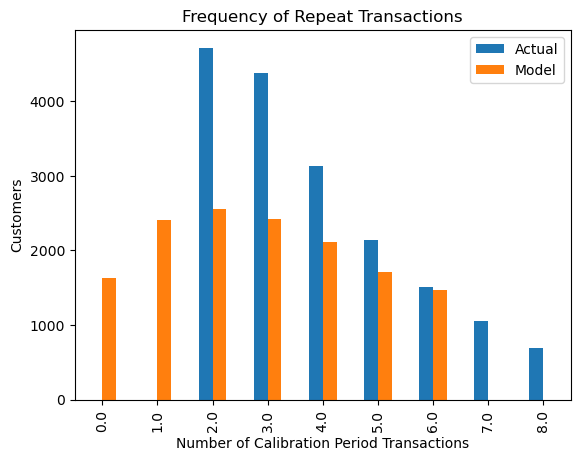

In [32]:
# Gerçek değer ile modeli karşılaştırma
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt

plot_period_transactions(bgf)

plt.show(block=True)

Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv
dataframe'ine ekleyiniz.

In [57]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,114.33


Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz.
• Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.

In [58]:
cltv_df["cltv"]  = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

# index numaraları rasgele olmuş bunu resetliyelim
cltv = cltv.reset_index()

In [45]:
#Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.


In [61]:
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1449.06,3327.78
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,767.36,3172.39
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,506.17,1662.61
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,166.71,1628.89
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,611.49,1623.81
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,778.05,1423.00


#Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması


Adım 1: 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz.

In [64]:
cltv_df["cltv_segment"]  = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

In [69]:
cltv_df.head(10)#kontrol amaçlı 10 gözleme bakalım

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,193.63,395.73,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,96.67,199.43,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,120.97,170.22,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,67.32,98.95,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,114.33,95.01,D
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,120.86,132.29,3.00,66.95,71.35,57.43,D
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,32.57,64.86,4.00,93.98,98.13,134.28,C
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,12.71,54.57,2.00,81.81,89.57,97.70,D
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,58.43,70.71,5.00,210.94,217.30,322.73,A
9,1143f032-440d-11ea-8b43-000d3a38a36f,61.71,96.00,2.00,82.98,90.81,75.22,D


Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.

In [74]:

#müşteri segmentine göre incelersek

cltv_df.groupby("cltv_segment").agg({"count", "mean", "sum"})

#bu grafiğe göre yorumlama yapabiliriz. örneğin monetary_cltv_avg inceleyelim.

#Yorum : A segmenti müşterilerin  satın alımları ve  ödemeleri yüksek olan müşteriler bu müşterilerimize özel kampanyalar yapabiliriz.
# Ürüm Numuneleri, hediyeler, seminerlere davet edilebilir.
# D segmenti müşterileri ise satın alımları çok düşük getirisi çok düşük olan müşteriler bu müşterilere kampanyalar için mailler gönderilebilir.Katolog paylaşılabilir. 



recency_cltv_weekly                 T_weekly                 frequency                monetary_cltv_avg                  exp_average_value                    cltv                 
                            mean count       sum     mean count       sum      mean count      sum              mean count        sum              mean count        sum   mean count        sum
cltv_segment                                                                                                                                                                                    
D                         139.00  4987 693193.86   162.18  4987 808807.71      3.77  4987 18795.00             93.15  4987  464547.05             98.69  4987  492172.44  80.34  4987  400657.96
C                          92.63  4986 461850.86   112.82  4986 562512.14      4.40  4986 21962.00            125.79  4986  627181.65            132.25  4986  659401.45 138.31  4986  689621.18
B                          81.99  4986 408794.00   100.33  4986 500228.00      5.09  4986 25392.00            160.64  4986  800933.96            168.00  4986  837650.88 199.53  4986  994870.78
A                          67.43  4986 336191.71    82.55  4986 411592.86      6.65  4986 33140.00            228.83  4986 1140952.07            238.02  4986 1186787.64 362.32  4986 1806505.09